Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>


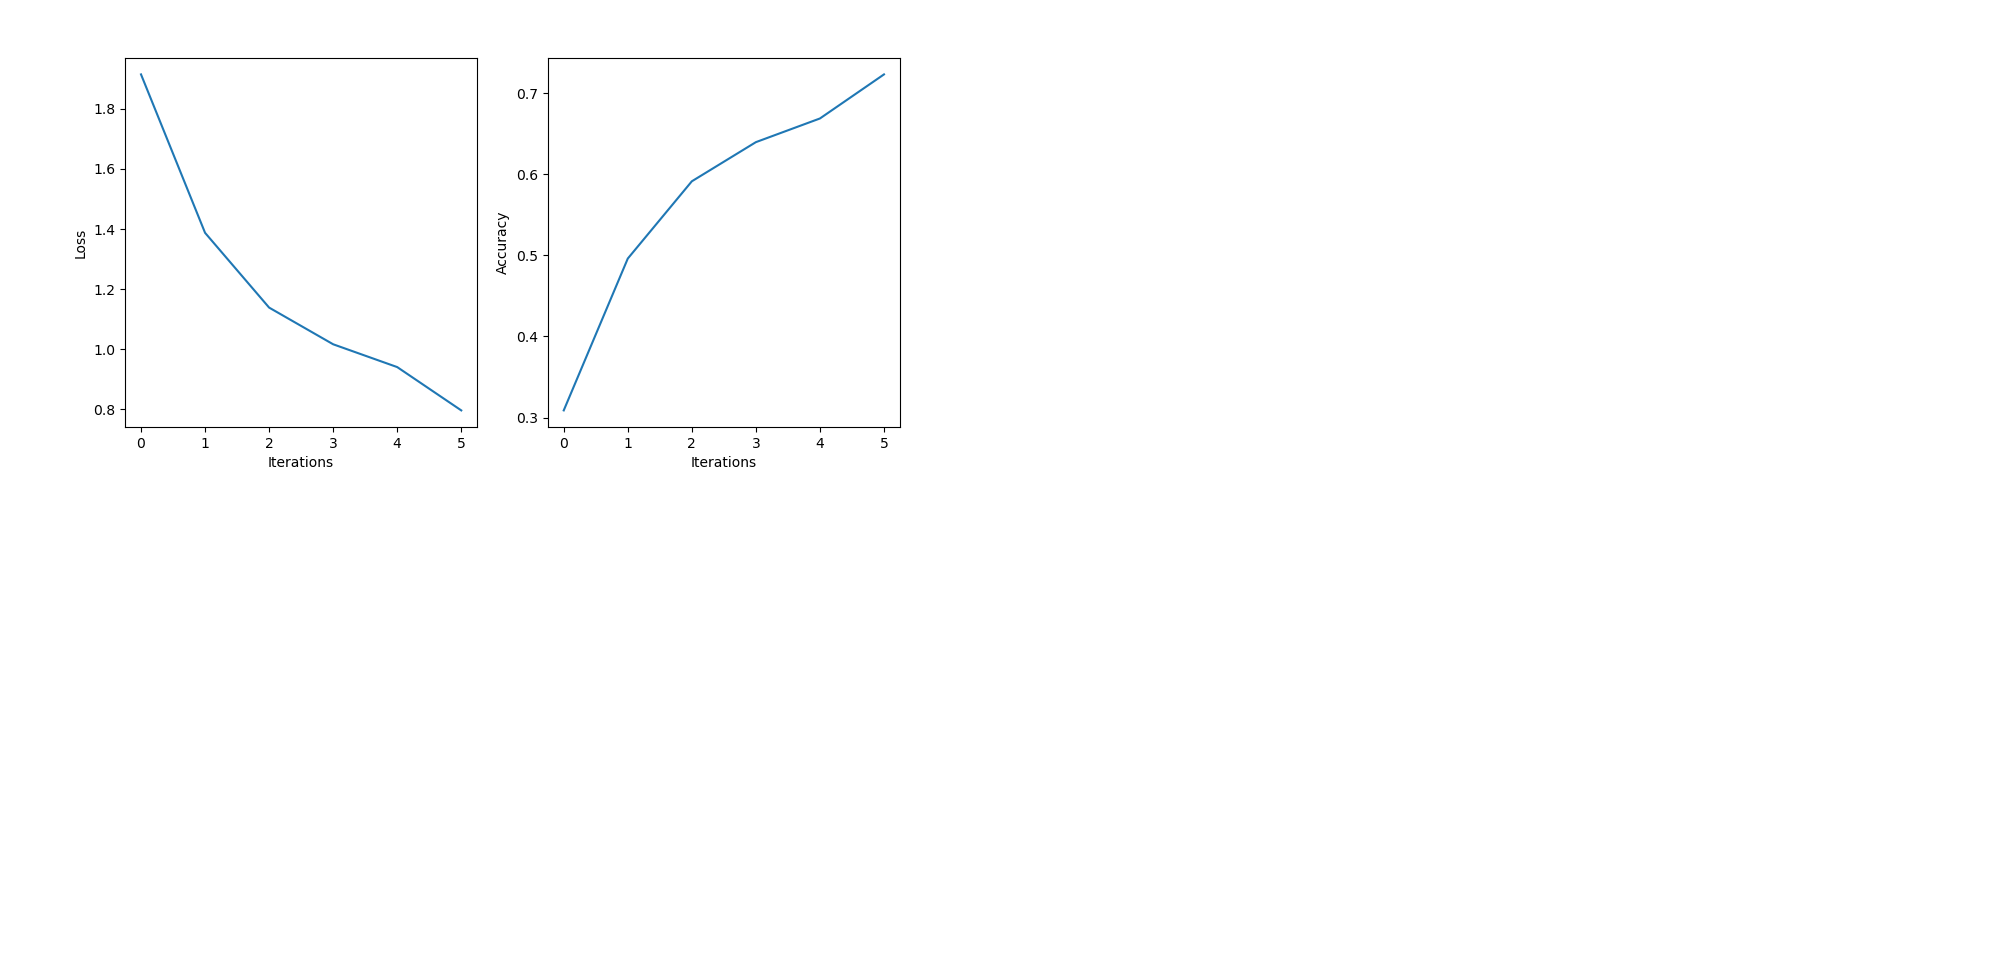


===> epoch: 1/200
train:
 500/500 [================================================================================>]  Step: 37ms | Tot: 18s352ms | Loss: 1.9149 | Acc: 30.880% (15440/50000)
test:
 100/100 [================================================================================>]  Step: 16ms | Tot: 1s560ms | Loss: 1.6219 | Acc: 41.190% (4119/10000)

===> epoch: 2/200
train:
 500/500 [================================================================================>]  Step: 36ms | Tot: 18s364ms | Loss: 1.3873 | Acc: 49.600% (24800/50000)
test:
 100/100 [================================================================================>]  Step: 15ms | Tot: 1s549ms | Loss: 1.3080 | Acc: 53.180% (5318/10000)

===> epoch: 3/200
train:
 500/500 [================================================================================>]  Step: 36ms | Tot: 18s372ms | Loss: 1.1384 | Acc: 59.126% (29563/50000)
test:
 100/100 [=========================================================================

KeyboardInterrupt: 

In [8]:
%matplotlib notebook

import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import torch.nn as nn
from GWDC import GWDC
import argparse
from plot import dynamicplot
from misc import progress_bar


CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def main():
    #epoch和batchsize可能需要调整
    parser = argparse.ArgumentParser(description="cifar-10 with PyTorch")
    parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
    parser.add_argument('--epoch', default=200, type=int, help='number of epochs tp train for')
    parser.add_argument('--trainBatchSize', default=100, type=int, help='training batch size')
    parser.add_argument('--testBatchSize', default=100, type=int, help='testing batch size')
    parser.add_argument('--cuda', default=torch.cuda.is_available(), type=bool, help='whether cuda is in use')
    args = parser.parse_args(args=[])

    solver = Solver(args)
    solver.run()


class Solver(object):
    def __init__(self, config):
        self.model = None
        self.lr = config.lr
        self.epochs = config.epoch
        self.train_batch_size = config.trainBatchSize
        self.test_batch_size = config.testBatchSize
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.device = None
        self.cuda = config.cuda
        self.train_loader = None
        self.test_loader = None

    def load_data(self):
        train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
        test_transform = transforms.Compose([transforms.ToTensor()])
        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=self.train_batch_size, shuffle=True)
        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=self.test_batch_size, shuffle=False)

    def load_model(self):
        if self.cuda:
            self.device = torch.device('cuda')
            cudnn.benchmark = True
        else:
            self.device = torch.device('cpu')

        self.model = torchvision.models.resnet34().to(self.device)
        #self.model = torchvision.models.densenet121().to(self.device)
        #选择resnet34&Densenet121
        
        self.optimizer = GWDC(self.model.parameters())
        #选择GWDC优化器
        #self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        #self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[75, 150], gamma=0.5)
        #使用GWDC时暂时不能使用self.scheduler
        self.criterion = nn.CrossEntropyLoss().to(self.device)

    def train(self):
        print("train:")
        self.model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for batch_num, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            prediction = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
            total += target.size(0)

            # train_correct incremented by one if predicted right
            train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

            progress_bar(batch_num, len(self.train_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                         % (train_loss / (batch_num + 1), 100. * train_correct / total, train_correct, total))

        return train_loss/ (batch_num + 1), train_correct / total

    def test(self):
        print("test:")
        self.model.eval()
        test_loss = 0
        test_correct = 0
        total = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.test_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                test_loss += loss.item()
                prediction = torch.max(output, 1)
                total += target.size(0)
                test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

                progress_bar(batch_num, len(self.test_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                             % (test_loss / (batch_num + 1), 100. * test_correct / total, test_correct, total))

        return test_loss, test_correct / total

    def save(self):
        model_out_path = "model.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def run(self):
        self.load_data()
        self.load_model()
        self.run_plot()
        accuracy = 0
        for epoch in range(1, self.epochs + 1):
            #self.scheduler.step(epoch)
            #使用GWDC时暂时不能使用self.scheduler
            print("\n===> epoch: %d/200" % epoch)
            train_result = self.train()
            self.plot.showplot(train_result[0],train_result[1])
            #print(train_result)
            test_result = self.test()
            accuracy = max(accuracy, test_result[1])
            if epoch == self.epochs:
                print("===> BEST ACC. PERFORMANCE: %.3f%%" % (accuracy * 100))
                self.save()
    def run_plot(self):
        self.plot = dynamicplot()
        self.plot.plotdefine()
        

#if __name__ == '__main__':
    #main()

main()